## 2nd reading session in the 2022/23 season 
In this session we have read this paper [Tabular Data: Deep Learning is Not All You Need]( https://arxiv.org/abs/2106.03253)
And we have decided to get our hands dirty with the code by training the XGB boost with the used parameters in the paper and the TabNet model that is cited in this paper then Ms.Hajer Benmeziane gaved us a challenge to combine (ensemble) the TabNet model the XGB boost one.In this notebook I have tried to use some Weighted Average Ensemble techniques and compare the results at the end in a table.  <br />
**Note : that we have trained both models on the Covertype dataset**
### The papers's abstract
>  A key element in solving real-life data science problems is selecting the types of models to use.
Tree ensemble models (such as XGBoost) are usually recommended for classification and regression
problems with tabular data. However, several deep learning models for tabular data have recently been
proposed, claiming to outperform XGBoost for some use cases. This paper explores whether these
deep models should be a recommended option for tabular data by rigorously comparing the new deep
models to XGBoost on various datasets. In addition to systematically comparing their performance,
we consider the tuning and computation they require. Our study shows that XGBoost outperforms
these deep models across the datasets, including the datasets used in the papers that proposed the
deep models. We also demonstrate that XGBoost requires much less tuning. On the positive side, we
show that an ensemble of deep models and XGBoost performs better on these datasets than XGBoost
alone.




## Data and packages imports and checking


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import tabulate

import torch

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

from pytorch_tabnet.tab_model import TabNetClassifier

np.random.seed(0)

In [2]:
cont_names = [            
    "Elevation",
    "Aspect",
    "Slope",
    "R_Hydrology",
    "Z_Hydrology",
    "R_Roadways",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Hillshade_3pm",
    "R_Fire_Points",
] # Continuous variables

cont_dict = {name: np.float64 for name in cont_names}
area_names = ['Wilderness_Area' + str(i + 1) for i in range(4)]
area_dict = {name: np.int64 for name in area_names}
soil_names = ['Soil_Type' + str(i + 1) for i in range(40)]
soil_dict = {name: np.int64 for name in soil_names}
bin_names = area_names + soil_names

target = 'Cover_Type'

names = cont_names + bin_names # All column names except target
dtypes_dict = {**cont_dict, **area_dict, **soil_dict}

In [3]:
data = pd.read_csv('covtype.data', header=None, names=names + [target], dtype=dtypes_dict)
data.head()

,Elevation,Aspect,Slope,R_Hydrology,Z_Hydrology,R_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,R_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,...,0,0,0,0,0,0,0,0,0,5
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,...,0,0,0,0,0,0,0,0,0,5
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,...,0,0,0,0,0,0,0,0,0,2
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,...,0,0,0,0,0,0,0,0,0,2
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,...,0,0,0,0,0,0,0,0,0,5


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Elevation         581012 non-null  float64
 1   Aspect            581012 non-null  float64
 2   Slope             581012 non-null  float64
 3   R_Hydrology       581012 non-null  float64
 4   Z_Hydrology       581012 non-null  float64
 5   R_Roadways        581012 non-null  float64
 6   Hillshade_9am     581012 non-null  float64
 7   Hillshade_Noon    581012 non-null  float64
 8   Hillshade_3pm     581012 non-null  float64
 9   R_Fire_Points     581012 non-null  float64
 10  Wilderness_Area1  581012 non-null  int64  
 11  Wilderness_Area2  581012 non-null  int64  
 12  Wilderness_Area3  581012 non-null  int64  
 13  Wilderness_Area4  581012 non-null  int64  
 14  Soil_Type1        581012 non-null  int64  
 15  Soil_Type2        581012 non-null  int64  
 16  Soil_Type3        58

In [5]:
print('data shape :', data.shape)

data shape : (581012, 55)


In [6]:
n_total = len(data)

train_val_indices, test_indices = train_test_split(
    range(n_total), test_size=0.2, random_state=0)
train_indices, valid_indices = train_test_split(
    train_val_indices, test_size=0.2 / 0.6, random_state=0)

In [7]:
categorical_columns = []
categorical_dims =  {}
for col in data.columns[data.dtypes == object]:
    print(col, data[col].nunique())
    l_enc = LabelEncoder()
    data[col] = data[col].fillna("VV_likely")
    data[col] = l_enc.fit_transform(data[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

for col in data.columns[data.dtypes == 'float64']:
    data.fillna(data.loc[train_indices, col].mean(), inplace=True)

In [8]:
unused_feat = []

features = [ col for col in data.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

## TabNet

In [9]:
model = TabNetClassifier(
    n_d=64, n_a=64, n_steps=5,
    gamma=1.5, n_independent=2, n_shared=2,
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=1,
    lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_fn=None , epsilon=1e-15
)

C:\Users\MON PC\AppData\Roaming\Python\Python310\site-packages\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [10]:
import os 
if os.getenv("CI", False):
    print("here")
# Take only a subsample to run CI
    X_train = data[features].values[train_indices][:1000,:]
    y_train = data[target].values[train_indices][:1000]
else:
    X_train = data[features].values[train_indices]
    y_train = data[target].values[train_indices]

X_valid = data[features].values[valid_indices]
y_valid = data[target].values[valid_indices]

X_test = data[features].values[test_indices]
y_test = data[target].values[test_indices]

In [11]:
max_epochs = 50 if not os.getenv("CI", False) else 2

In [12]:
from pytorch_tabnet.augmentations import ClassificationSMOTE
aug = ClassificationSMOTE(p=0.2)

model.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    max_epochs=max_epochs, patience=100,
    batch_size=16384, virtual_batch_size=256,
    augmentations=aug
) 

epoch 0  | loss: 1.22774 | train_accuracy: 0.05808 | valid_accuracy: 0.05714 |  0:00:34s
epoch 1  | loss: 0.78388 | train_accuracy: 0.03543 | valid_accuracy: 0.0354  |  0:01:05s
epoch 2  | loss: 0.73506 | train_accuracy: 0.0357  | valid_accuracy: 0.03559 |  0:01:37s
epoch 3  | loss: 0.71173 | train_accuracy: 0.03585 | valid_accuracy: 0.03566 |  0:02:07s
epoch 4  | loss: 0.69748 | train_accuracy: 0.03561 | valid_accuracy: 0.0355  |  0:02:35s
epoch 5  | loss: 0.68411 | train_accuracy: 0.0356  | valid_accuracy: 0.0355  |  0:03:05s
epoch 6  | loss: 0.67533 | train_accuracy: 0.12261 | valid_accuracy: 0.12381 |  0:03:34s
epoch 7  | loss: 0.66557 | train_accuracy: 0.0635  | valid_accuracy: 0.06441 |  0:04:04s
epoch 8  | loss: 0.65848 | train_accuracy: 0.08809 | valid_accuracy: 0.08809 |  0:04:34s
epoch 9  | loss: 0.65074 | train_accuracy: 0.11824 | valid_accuracy: 0.11732 |  0:05:03s
epoch 10 | loss: 0.64568 | train_accuracy: 0.20514 | valid_accuracy: 0.20543 |  0:05:33s
epoch 11 | loss: 0.64

C:\Users\MON PC\AppData\Roaming\Python\Python310\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


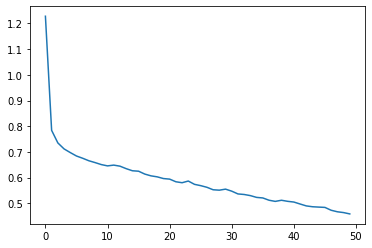

In [13]:
# plot losses
plt.plot(model.history['loss'])

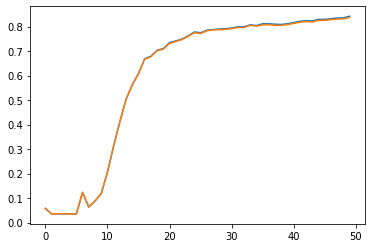

In [14]:
# plot accuracy
plt.plot(model.history['train_accuracy'])
plt.plot(model.history['valid_accuracy'])

In [26]:
from sklearn.metrics import log_loss
preds_mapper = { idx : class_name for idx, class_name in enumerate(model.classes_)}

preds_tabnet = model.predict_proba(X_test)

#y_pred_tabnet = np.vectorize(preds_mapper.get)(np.argmax(preds_tabnet, axis=1))
y_pred = np.argmax(preds_tabnet, axis=1)
test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)
tab_loss = log_loss(y_test, preds_tabnet)
print(f"BEST VALID SCORE FOR : {model.best_cost}")
print(f"FINAL TEST SCORE FOR : {test_acc}")
print(f"TABNET LOSS : {tab_loss}")


BEST VALID SCORE FOR : 0.8372628874962081
FINAL TEST SCORE FOR : 0.8396426942505787
TABNET LOSS : 0.38437015447779066


## XGBoost


In [16]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_valid = le.fit_transform(y_valid)
y_test = le.fit_transform(y_test)

In [ ]:
from xgboost import XGBClassifier
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe,Trials

def score(params):
    print("Training with params: ")
    print(params)
    num_round = int(params['n_estimators'])
    del params['n_estimators']
    xgb  = XGBClassifier(params)
    xgb.fit(X_train, 
            y_train, 
            early_stopping_rounds=5, 
            eval_set=[(X_train, y_train), (X_valid, y_valid), (X_test, y_test)])
            
    results = xgb.evals_result()
    proba = xgb.predict_proba(X_test)
    accuracy_ = accuracy_score(y_pred=np.argmax(proba,axis=1), y_true=y_test)
    score = results['validation_2']['mlogloss'][-1]
    
    print("\tScore {0}\n\n".format(score))
    return {'loss': score, 'status': STATUS_OK,"accuracy" : accuracy_}
random_state = 0
space = {
        'n_estimators': hp.uniform('n_estimators', 100, 4000),
        'eta': hp.loguniform('eta', 1e-7, 1),

        'max_depth':  hp.quniform('max_depth', 1,10,1),
        'min_child_weight': hp.loguniform('min_child_weight', 1e-16, 1e5),
        'subsample': hp.uniform('subsample', 0.2, 1),
        'gamma': hp.choice('gamma', [0, hp.loguniform('gamma_', 1e-16, 1e2) ]),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.2, 1),
        'colsample_bylevel': hp.uniform('colsample_bylevel', 0.2, 1),
        'alpha': hp.choice('alpha', [0, hp.loguniform('alpha_', 1e-16, 1e2) ]),
        'lambda': hp.choice('lamda', [0, hp.loguniform('lambda_',1e-16, 1e2) ]),
        'seed': random_state
    }
trials = Trials()
# Use the fmin function from Hyperopt to find the best hyperparameters
best = fmin(score, space, algo=tpe.suggest, 
                trials=trials, 
                max_evals=10)
print("The best hyperparameters are: ", "\n")
print(best)
# train with the best parameters
xgb  = XGBClassifier(best)
xgb.fit(X_train, 
            y_train, 
            early_stopping_rounds=5, 
            eval_set=[(X_train, y_train), (X_valid, y_valid), (X_test, y_test)])

In [18]:
#XGBoost loss & accuracy
XGB_accuracy = [t["result"]["accuracy"] for t in trials][-1]
XGB_loss = [t["result"]["loss"] for t in trials][-1]
print(f"XGB accuracy :  {XGB_accuracy}")
print(f"XGB loss :  {XGB_loss}")

XGB accuracy :  0.8699775393062141
XGB loss :  0.32675059816777635


## Challenge : Combining the XGB boost and the TabNet (The ensemble)


##### prediction probabilities


In [19]:
#get the XGB predictions
pred_XGB = xgb.predict_proba(X_test)
#get the TabNet predictions
pred_TabNet = model.predict_proba(X_test)

##### Weighted by 1/2 (the mean of the predictions)
$$
Predictions = Argmax(\frac{1}{2} × TabNet\_Test\_predictions + \frac{1}{2} × XGB\_test\_Predictions) = Argmax(mean(TabNet\_Test\_predictions ,XGB\_test\_Predictions))
$$

In [27]:
weighted = (pred_XGB + pred_TabNet) / 2
weighted_acuracy0 = accuracy_score(y_pred=np.argmax(weighted,axis=1), y_true=y_test)
weighted_acuracy0

0.8710532430315913

##### Weighted by the negative of the loss
$$
Predictions = Argmax(\frac{-TabNet\_Test\_Loss × TabNet\_Test\_predictions + -XGB\_test\_Loss × XGB\_test\_Predictions}{-(TabNet\_Test\_Loss + XGB\_test\_Loss)})
$$

In [28]:
weighted = ((-XGB_loss * pred_XGB) + (-tab_loss * pred_TabNet)) / (-tab_loss -XGB_loss)
weighted_acuracy1 = accuracy_score(y_pred=np.argmax(weighted,axis=1), y_true=y_test)
weighted_acuracy1

0.8690137087682762

##### Weighted by the accuracy
$$
Predictions = Argmax(\frac{TabNet\_test\_accuracy × TabNet\_Test\_predictions + XGB\_test\_accuracy × XGB\_test\_Predictions}{TabNet\_Test\_Accuracy + XGB\_test\_accuracy})
$$

In [29]:
weighted = ((XGB_accuracy * pred_XGB) + (test_acc * pred_TabNet)) / (tab_loss + XGB_loss)
weighted_acuracy2 = accuracy_score(y_pred=np.argmax(weighted,axis=1), y_true=y_test)
weighted_acuracy2

0.8715093414111512

##### Weighted by the loss inverse
$$
Predictions = Argmax(\frac{\frac{1}{TabNet\_Test\_Loss} × TabNet\_Test\_predictions + \frac{1}{XGB\_test\_Loss} × XGB\_test\_Predictions}{\frac{1}{TabNet\_Test\_Loss} + \frac{1}{XGB\_test\_Loss}})
$$

In [30]:
weighted = (((1/XGB_loss) * pred_XGB) + ((1/tab_loss) * pred_TabNet)) / ((1/XGB_loss) + (1/tab_loss))
weighted_acuracy3 = accuracy_score(y_pred=np.argmax(weighted,axis=1), y_true=y_test)
weighted_acuracy3

0.8727657633623916

##### Weighted by the loss & the accuracy
$$
Predictions = Argmax(\frac{(-TabNet\_test\_loss + TabNet\_test\_accuracy ) × TabNet\_Test\_predictions +(-XGB\_test\_loss + XGB\_test\_accuracy) × XGB\_test\_Predictions}{(-XGB\_test\_loss + XGB\_test\_accuracy) + (-TabNet\_test\_loss + TabNet\_test\_accuracy )})
$$

In [31]:
weighted = (((-XGB_loss+XGB_accuracy) * pred_XGB) + ((-tab_loss + test_acc) * pred_TabNet)) / (-tab_loss + test_acc  - XGB_loss + XGB_accuracy )
weighted_acuracy4 = accuracy_score(y_pred=np.argmax(weighted,axis=1), y_true=y_test)
weighted_acuracy4

0.8728776365498309

In [37]:
table = [
    ["model","accuracy","loss"],
    ["TabNet",round(test_acc,4),tab_loss],
    ["XGB boost",round(XGB_accuracy,4),XGB_loss],
    ["ensemble weighted by accuracy",round(weighted_acuracy2,4),"//"],
    ["ensemble weighted by 1/2 (mean)",round(weighted_acuracy0,4),"//"],
    ["ensemble weighted by the negative of the loss",str(round(weighted_acuracy1,4)),"//"],
    ["ensemble weighted by the loss inverse",str(round(weighted_acuracy3,4)),"//"],
    ["ensemble weighted by the loss & accuracy",str(round(weighted_acuracy4,4)) + " (best)","//"],
]
print(tabulate.tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒═══════════════════════════════════════════════╤═══════════════╤═════════════════════╕
│ model                                         │ accuracy      │ loss                │
╞═══════════════════════════════════════════════╪═══════════════╪═════════════════════╡
│ TabNet                                        │ 0.8396        │ 0.38437015447779066 │
├───────────────────────────────────────────────┼───────────────┼─────────────────────┤
│ XGB boost                                     │ 0.87          │ 0.32675059816777635 │
├───────────────────────────────────────────────┼───────────────┼─────────────────────┤
│ ensemble weighted by accuracy                 │ 0.8715        │ //                  │
├───────────────────────────────────────────────┼───────────────┼─────────────────────┤
│ ensemble weighted by 1/2 (mean)               │ 0.8711        │ //                  │
├───────────────────────────────────────────────┼───────────────┼─────────────────────┤
│ ensemble weighted by the negat